# Staring Array Modelling - Infrared sensor


This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module models the signal and noise in CCD and CMOS staring array sensors.  The code is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf)

Good references for this work include James R Janesick's books ['Photon Transfer'](http://spie.org/Publications/Book/725073) and ['Scientific Charge-Coupled Devices'](http://spie.org/Publications/Book/374903)



In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab
import scipy.constants as const
import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

# import xlsxwriter

import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
import pyradi.rypflux as rypflux
import pyradi.ryplanck as ryplanck

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at stated dpi
import matplotlib as mpl
plotdpi = 72
mpl.rc("savefig", dpi=plotdpi)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

# Infrared sensor example

The infrared sensor example has the following design characteristics:

| Characteristic | Value |Unit |  Motivation |
|--|--|--|--| 
|Spectral response |3.7--4.9| $\mu$m| detector specification|
|Pixel size (x and y) |12| $\mu$m| detector specification|
|Pixel fill factor  |0.95| | detector specification|
|Detector temperature  |80|K | detector specification|
|Detector external quantum efficiency  |0.8| | detector specification|
|Detector internal quantum efficiency  |0.75| | detector specification|
|Number rows | 144 | - |  detector specification|
|Number columns | 256 | - |  detector specification|
|Detector PRNU  stddev | 0.2 | | detector specification|
|Well capacity at 1 V|3.2e+6 |e | detector specification|
|Sense node voltage| 3.0 $\rightarrow$ 1.0 |V | detector specification|
|F-number | 3.2 | - | detector specification|
|Band gap 0~K | 0.235 | eV | material property|
|Varshni A | 0.00068 |  | material model|
|Varshni B | 500 |  | material model|
|Dark FOM | 4e-9 | nA/cm$^2$ | material model|
|Dark cm | 1 |  | material model|
|Dark FPN stddev | 0.4 |  | material model|
|Well capacitance at 1.0 V|5.13e-13| F | by calculation|
|k1 | 5.13e-13 | CV |by calculation|
|Gain at 1.0 V |3.125e-07 | V/e| by calculation|
|Pixel IFOV (x and y) |100.0e-6| rad| design choice|
|Frame time | 0.02 | s |  design choice|
|Focal length | 0.12 | m | design choice|
|Full field angle | 0.84 | deg| focal length and detector|

Charge well (sense node) capacitance $C = nq/V$. The charge well is filled to capacity at the minimum sense node voltage $C = \num{3.2e6}\times\num{1.6e-19}/1.0= \num{0.513e-12}$~F.  Then $k_1=CV=\num{0.513e-12}\times 1=\num{0.513e-12}$.

Sense node gain is given by $V/n = q/C = \num{1.6e-19}/\num{0.513e-12}=\num{3.12e-07}$ V/e.



Well capacitance 5.12696518656e-13 F at 1.0 V
k1 is 5.12696518656e-13
Gain 3.125e-07 V/e at 1.0 V


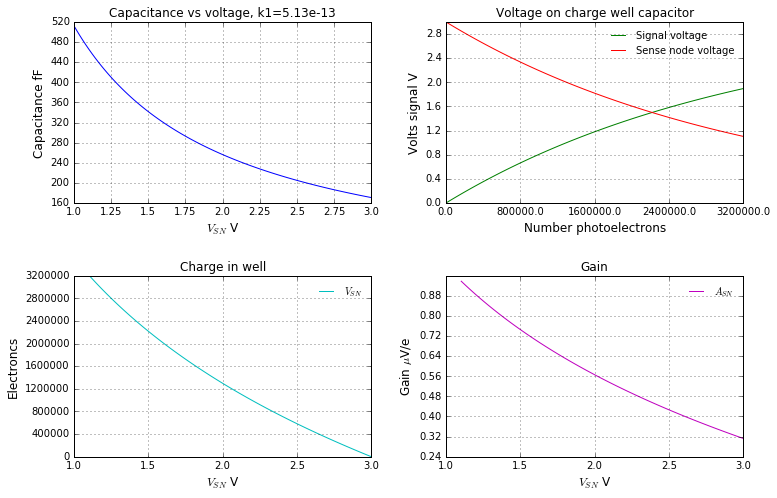

In [47]:
nwell = 3.2e6
vref = 3.0
vsnmin = 1.0
cwell = nwell * const.e / vsnmin
k1 = cwell * vsnmin
gain = const.e/cwell
print('Well capacitance {} F at {} V'.format(cwell,vsnmin))
print('k1 is {}'.format(k1))
print('Gain {} V/e at {} V'.format(gain,vsnmin))

nphelec = np.linspace(0,nwell,100)
vsnp = np.linspace(vsnmin,vref,100)
p = ryplot.Plotter(1,2,2,figsize=(12,8));
p.plot(1,vsnp,1e15*k1/vsnp,'Capacitance vs voltage, k1={:.2e}'.format(k1),
       '$V_{SN}$ V','Capacitance fF');
vsignal = vref * (1.0 - np.exp(- nphelec * const.e / (k1)))
vsn = vref * (np.exp(- nphelec * const.e / (k1)))
p.plot(2,nphelec, vsignal,'Voltage on charge well capacitor','Number photoelectrons','Volts signal V',
       label=['Signal voltage'],maxNX=5);
p.plot(2,nphelec, vsn,label=['Sense node voltage'],maxNX=5);

nelec = -(k1/const.e)*np.log(vsn/vref)
p.plot(3, vsn, nelec,'Charge in well','$V_{SN}$ V','Electroncs',label=['$V_{SN}$'],maxNX=5);
p.plot(4, vsn, 1e6*const.e*vsnp/k1,'Gain','$V_{SN}$ V','Gain $\mu$V/e',label=['$A_{SN}$'],maxNX=5);



The following code sets up the sensor model data for an infrared sensor.

Files remaining open, not closed after use, poses a problem in the notebook context where cells may be executed indivdually.  To limit the occurence of open files we open and close the file in each cell.

In [48]:
#set up the parameters for this run and open the HDF5 file
outfilenameIR = 'OutputIR'
prefix = 'PA'
hfname = 'image-E-W-m2-detector-100-256-100-256.hdf5'
urlname = 'https://github.com/NelisW/pyradi/raw/master/pyradi/data/{}'.format(hfname)
pathtoimage = ryfiles.downloadFileUrl(urlname,saveFilename=hfname)

#open the file to create data structure and store the results, remove if exists
hdffilenameIR = '{}{}.hdf5'.format(prefix, outfilenameIR)
if os.path.isfile(hdffilenameIR):
    os.remove(hdffilenameIR)

In [49]:
strh5 = ryfiles.open_HDF(hdffilenameIR)
# Light Noise parameters
strh5['rystare/photonshotnoise/activate'] = True #photon shot noise.

#sensor parameters
strh5['rystare/sensortype'] = 'CMOS' # CMOS/CCD must be in capitals

strh5['rystare/photondetector/operatingtemperature'] = 80. # operating temperature, [K]
strh5['rystare/photondetector/geometry/fillfactor'] = 0.95 # Pixel Fill Factor for full-frame CCD photo sensors.
strh5['rystare/photondetector/integrationtime'] = 0.005 # Exposure/Integration time, [sec].
strh5['rystare/photondetector/externalquantumeff'] = 1.  # external quantum efficiency, fraction not reflected.
strh5['rystare/photondetector/quantumyield'] = 1. # number of electrons absorbed per one photon into material bulk

# photo response non-uniformity noise (PRNU), or also called light Fixed Pattern Noise (light FPN)
strh5['rystare/photondetector/lightPRNU/activate'] = True
strh5['rystare/photondetector/lightPRNU/seed'] = 362436069
strh5['rystare/photondetector/lightPRNU/model'] = 'Janesick-Gaussian' 
strh5['rystare/photondetector/lightPRNU/sigma'] = 0.002 # sigma [about 1\% for CCD and up to 5% for CMOS];

# detector material bandgap properties 
strh5['rystare/photondetector/varshni/Egap0'] = 0.235  #bandgap energy for 0 degrees of K. [eV]
strh5['rystare/photondetector/varshni/varA'] = 3e-04 #Si material parameter, [eV/K].
strh5['rystare/photondetector/varshni/varB'] = 500. #Si material parameter, [K].

# Dark Current Noise parameters
strh5['rystare/photondetector/darkcurrent/activate'] = True
strh5['rystare/photondetector/darkcurrent/ca'] = 2.78e4 # for density in m2
strh5['rystare/photondetector/darkcurrent/ed'] = 2. 
strh5['rystare/photondetector/darkcurrent/densityAm2'] = 2e-6 # dark current density [A/m2].  
strh5['rystare/photondetector/darkcurrent/shotnoise/activate'] = True # dark current shot noise
strh5['rystare/photondetector/darkcurrent/shotnoise/seed'] = 6214069 
strh5['rystare/photondetector/darkcurrent/shotnoise/model'] = 'Gaussian' 

#dark current Fixed Pattern uniformity 
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/activate'] = True
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/seed'] = 362436128
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/model'] = 'Janesick-Gaussian' #suitable for long exposures
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/sigma'] = 0.4 #lognorm_sigma.

#sense node charge to voltage
strh5['rystare/sensenode/gain'] = 3.125e-07 # Sense node gain, A_SN [V/e]
strh5['rystare/sensenode/vrefreset'] = 3. # Reference voltage to reset the sense node. [V] typically 3-10 V.
strh5['rystare/sensenode/vsnmin'] = 1.0 # Minimum voltage on sense node, max well charge [V] typically < 1 V.
strh5['rystare/sensenode/gainresponse/type'] = 'linear'
strh5['rystare/sensenode/gainresponse/k1'] = 5.13e-13 # nonlinear capacitance is given by C =  k1/V
if strh5['rystare/sensenode/gainresponse/type'] in ['nonlinear']:
    strh5['rystare/sensenode/fullwellelectronselection/fullwellelectrons'] = \
        -(strh5['rystare/sensenode/gainresponse/k1'].value/const.e) * \
        np.log(strh5['rystare/sensenode/vsnmin'].value/strh5['rystare/sensenode/vrefreset'].value)
else:
    strh5['rystare/sensenode/fullwellelectronselection/fullwellelectrons'] = 3.2e6 # full well of the pixel (how many electrons can be stored in one pixel), [e]
strh5['rystare/sensenode/resetnoise/activate'] = True
strh5['rystare/sensenode/resetnoise/seed'] = 2154069 
strh5['rystare/sensenode/resetnoise/model'] = 'Gaussian' 
strh5['rystare/sensenode/resetnoise/factor'] = 0.8 #[0,1]the compensation factor of the Sense Node Reset Noise: 

#source follower
strh5['rystare/sourcefollower/gain'] = 1. # Source follower gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/dataclockspeed'] = 10e6 #Hz data rate clocking speed.
strh5['rystare/sourcefollower/freqsamplingdelta'] = 10000. #Hz spectral sampling spacing
strh5['rystare/sourcefollower/noise/activate'] = True
strh5['rystare/sourcefollower/noise/seed'] = 6724069
strh5['rystare/sourcefollower/noise/flickerCornerHz'] = 1e6 #flicker noise corner frequency $f_c$ in [Hz], where power spectrum of white and flicker noise are equal [Hz].
strh5['rystare/sourcefollower/noise/whitenoisedensity'] = 15e-9 #thermal white noise [\f$V/Hz^{1/2}\f$, typically \f$15 nV/Hz^{1/2}\f$ ]
strh5['rystare/sourcefollower/noise/deltaindmodulation'] = 1e-8 #[A] source follower current modulation induced by RTS [CMOS ONLY]
strh5['rystare/sourcefollower/nonlinearity/activate'] = True
strh5['rystare/sourcefollower/nonlinearity/ratio'] = 1.05 # > 1 for lower signal, < 1 for higher signal

#dark current Offset Fixed Pattern 
strh5['rystare/sourcefollower/fpoffset/activate'] = True
strh5['rystare/sourcefollower/fpoffset/model'] = 'Janesick-Gaussian'
strh5['rystare/sourcefollower/fpoffset/sigma'] = 0.0005 # percentage of (V_REF - V_SN)
strh5['rystare/sourcefollower/fpoffset/seed'] = 362436042

# Correlated Double Sampling (CDS)
strh5['rystare/sourcefollower/CDS/gain'] = 1. # CDS gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/CDS/sampletosamplingtime'] = 1e-6 #CDS sample-to-sampling time [sec].

# Analogue-to-Digital Converter (ADC)
strh5['rystare/ADC/num-bits'] = 16. # noise is more apparent on high Bits
strh5['rystare/ADC/offset'] = 0. # Offset of the ADC, in DN
strh5['rystare/ADC/nonlinearity/activate'] = True 
strh5['rystare/ADC/nonlinearity/ratio'] = 1.05

#For testing and measurements only:
strh5['rystare/darkframe'] = False # True if no signal, only dark

    
strh5.flush()
strh5.close()

Download the image file from the GitHub directory. Normally you will prepare this file for your specific application.  The format for this file is described [here](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html#pyradi.rystare.create_HDF5_image).

In [50]:

if pathtoimage is not None:
    imghd5 = ryfiles.open_HDF(pathtoimage)
else:
    imghd5 = None  

The input data has been set up, now execute the model. To test the model performance at the limits, uncomment one of the two `scaleInput` lines.  The first line provides a signal with small SNR whereas the second line provides a signal that saturates the well.

In [51]:
##
scaleInput = 1 

if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilenameIR)
    
    #images must be in photon rate irradiance units q/(m2.s)
    
    strh5['rystare/equivalentSignal'] = scaleInput * imghd5['image/equivalentSignal'].value
    strh5['rystare/signal/photonRateIrradianceNoNoise'] = scaleInput * imghd5['image/PhotonRateIrradianceNoNoise'].value
    strh5['rystare/signal/photonRateIrradiance'] = scaleInput * imghd5['image/PhotonRateIrradiance'].value
    strh5['rystare/pixelPitch'] = imghd5['image/pixelPitch'].value
    strh5['rystare/imageName'] = imghd5['image/imageName'].value
    strh5['rystare/imageFilename'] = imghd5['image/imageFilename'].value
    strh5['rystare/imageSizePixels'] = imghd5['image/imageSizePixels'].value
    strh5['rystare/wavelength'] = imghd5['image/wavelength'].value
    strh5['rystare/imageSizeRows'] = imghd5['image/imageSizeRows'].value
    strh5['rystare/imageSizeCols'] = imghd5['image/imageSizeCols'].value
    strh5['rystare/imageSizeDiagonal'] = imghd5['image/imageSizeDiagonal'].value
    strh5['rystare/equivalentSignalUnit'] = imghd5['image/equivalentSignalUnit'].value
    strh5['rystare/equivalentSignalType'] = imghd5['image/equivalentSignalType'].value
    strh5['rystare/EinUnits'] = imghd5['image/EinUnits'].value

    #calculate the noise and final images
    strh5 = rystare.photosensor(strh5) # here the Photon-to-electron conversion occurred.
    strh5.flush()
    strh5.close()


In [52]:
print(hdffilenameIR)

PAOutputIR.hdf5


Print some statistics of the sensor, noise and image

In [53]:
print(rystare.get_summary_stats(hdffilenameIR))

PAOutputIR.hdf5
Image file name             : image-E-W-m2-detector-100-256-100-256.hdf5
Image name                  : E-W-m2-detector-100-256-1
Input image type            : W/m2 on detector plane
Sensor type                 : CMOS 
Pixel pitch                 : [  1.20000000e-05   1.20000000e-05] m
Image size diagonal         : 0.00329805761017 m
Image size pixels           : [100 256] 
Fill factor                 : 0.95
Full well electrons         : 3200000.0 e
Integration time            : 0.005 s
Wavelength                  : 4.5e-06 m
Operating temperature       : 80.0 K
Max equivalent input signal : 0.120830185711 W/m2
Min equivalent input signal : 0.0596921443939 W/m2
EquivalentSignal type       : Irradiance W/m2
PhotonRateIrradianceNoNoise : q/(m2.s) mean=1.97865e+18, var=inf
SignalPhotonRateIrradiance  : q/(m2.s) mean=1.97865e+18, var=inf
SignalPhotonsNU             : q/(m2.s) mean=1.97866e+18, var=1.67417e+35
signalLightNoShotNoise      : e mean=1.35340e+06, var=7.83271e+10


Print some statistics of the sensor, noise and image

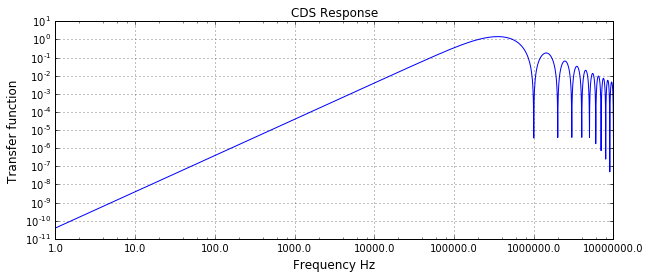

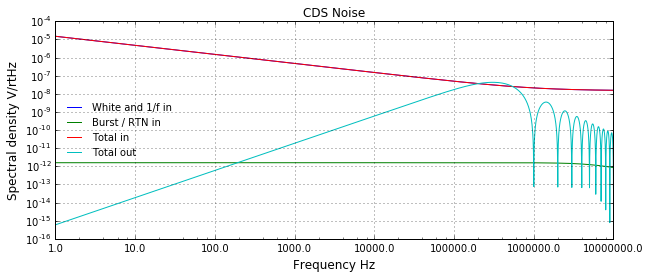

In [54]:
#open the sensor data file
%matplotlib inline
strh5 = ryfiles.open_HDF(hdffilenameIR)
p = ryplot.Plotter(1,1,1,figsize=(10,4))
p.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Response',
        'Frequency Hz','Transfer function')
q = ryplot.Plotter(2,1,1,figsize=(10,4))
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumwhiteflicker'].value.T),label=['White and 1/f in'])
if strh5['rystare/sensortype'].value in ['CMOS']:
    q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumRTN'].value.T), label=['Burst / RTN in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T),label=['Total in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T) * strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Noise',
        'Frequency Hz','Spectral density V/rtHz',label=['Total out'])
strh5.flush()
strh5.close()

In [55]:
def plotResults(imghd5, hdffilenameIR, arrayname, bins=50, plotscale=1.0, logscale=False):
    if imghd5 is not None and hdffilenameIR is not None:
        #open the sensor data file
        strh5 = ryfiles.open_HDF(hdffilenameIR)
        #get the prescribed array
        arr = strh5['{}'.format(arrayname)].value 
        maxarr = np.max(arr)
        arr = strh5['{}'.format(arrayname)].value * plotscale
        arr = np.where(arr > maxarr, maxarr,arr) / plotscale
        if logscale:
            arr = np.log10(arr + 0.5)
            ptitle = "log('{}'+0.5)".format(arrayname.replace('rystare/',''))
        else:
            ptitle = "'{}'".format(arrayname.replace('rystare/',''))
        
        his, binh = np.histogram(arr,bins=bins)
        
        if np.min(arr) != np.max(arr):
            arrshift = arr - np.min(arr)
            arrshift = 255 * arrshift/np.max(arrshift)
            p = ryplot.Plotter(1,1,1,figsize=(8, 2))
#             p.showImage(1, arr, ptitle=ptitle, cmap=ryplot.cubehelixcmap(), cbarshow=True);
            p.showImage(1, arr, ptitle=ptitle, cmap=mcm.jet, cbarshow=True);
            q = ryplot.Plotter(2,1,1,figsize=(8, 2))
            q.showImage(1, arrshift, ptitle=ptitle, cmap=mcm.gray, cbarshow=False);
        if not logscale:
            r = ryplot.Plotter(3,1,1,figsize=(7, 2))
            r.plot(1, (binh[1:]+binh[:-1])/2, his, 
                   '{}, {} bins'.format(arrayname.replace('rystare/',''), bins), 
                   'Magnitude','Counts / bin',maxNX=5)

        strh5.flush()
        strh5.close()

The graph in the rest of the document shows signals at the stations marked in the signal flow diagram shown below.

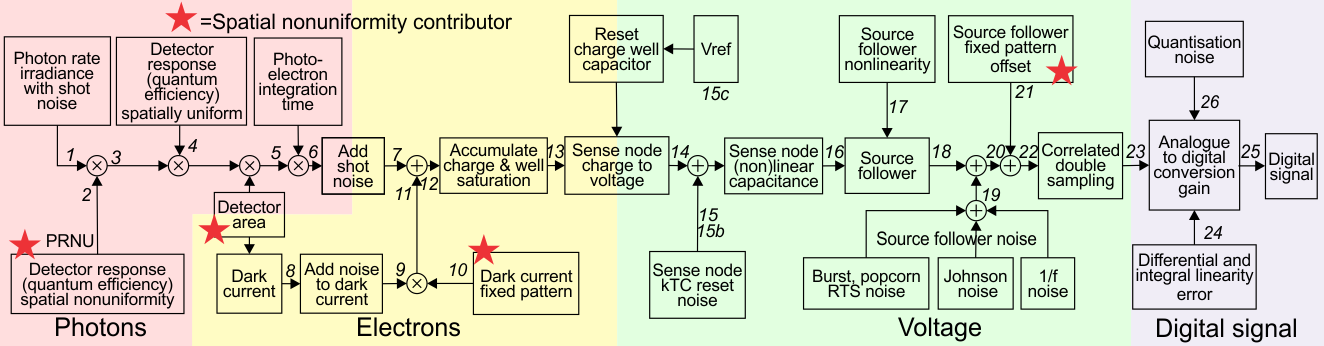

In [56]:
display(Image(filename='images/camerascheme-horiz.png', width=1000))

The following description follows  the signal through the processing chain, step by step, showing the relevant signal or noise at that step.

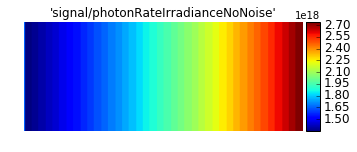

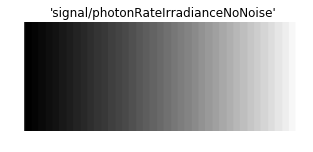

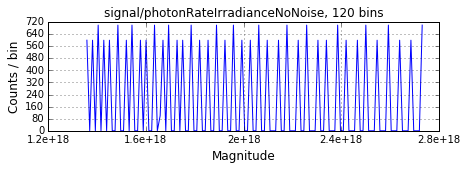

In [57]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/photonRateIrradianceNoNoise', bins=120) 

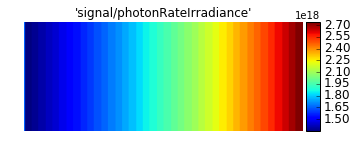

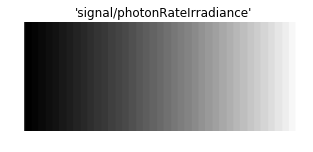

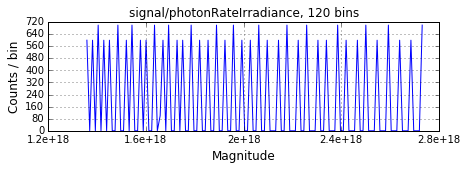

In [58]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/photonRateIrradiance', bins=120) 

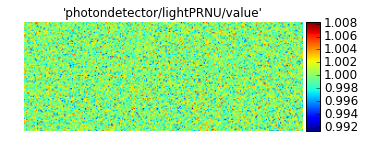

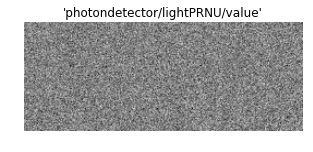

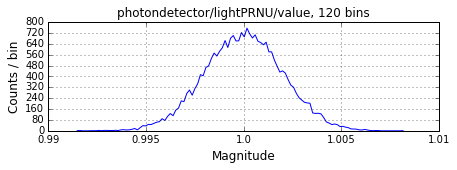

In [59]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/photondetector/lightPRNU/value', bins=120) 

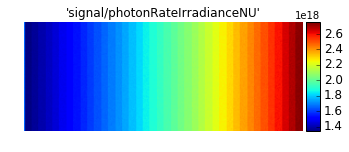

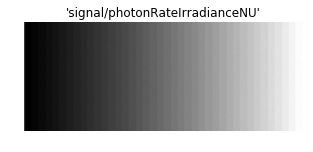

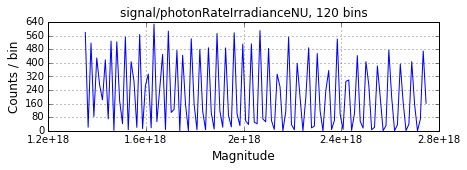

In [60]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/photonRateIrradianceNU', bins=120) 

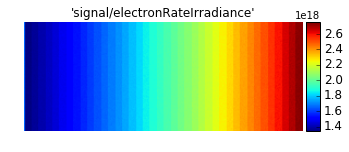

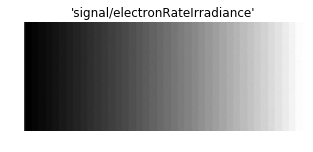

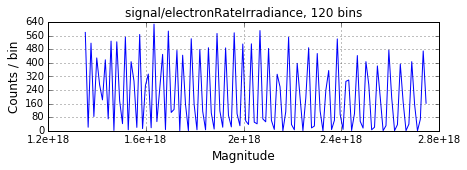

In [61]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electronRateIrradiance', bins=120) 

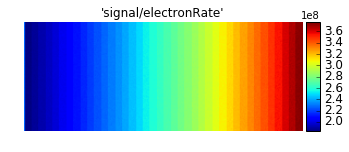

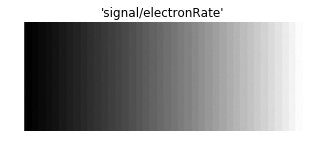

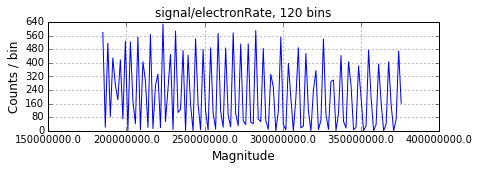

In [62]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electronRate', bins=120) 

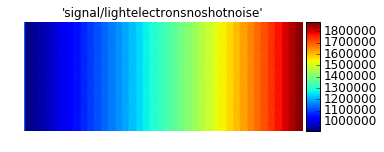

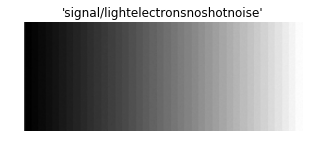

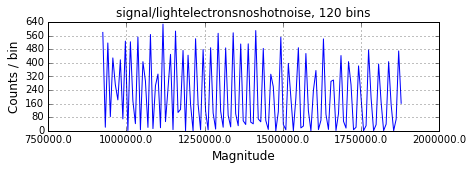

In [63]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/lightelectronsnoshotnoise', bins=120) 

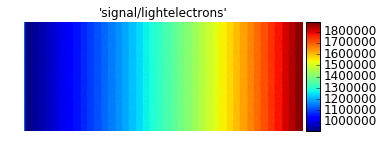

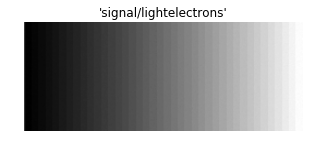

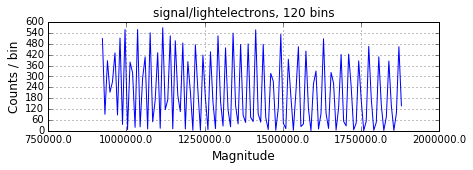

In [64]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/lightelectrons', bins=120) 

In [65]:
##
strh5 = ryfiles.open_HDF(hdffilenameIR)
print('Average dark current {:.3e} electrons'.format(strh5['rystare/darkcurrentelectronsnonoise'].value))
strh5.flush()
strh5.close()


Average dark current 9.004e+00 electrons


Before dark FPN:
Minimum dark current 0.000e+00 electrons
Average dark current 9.008e+00 electrons
Maximum dark current 2.300e+01 electrons
After dark FPN:
Minimum dark current 0.000e+00 electrons
Average dark current 9.041e+00 electrons
Maximum dark current 3.631e+01 electrons


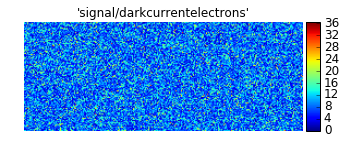

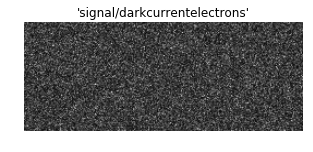

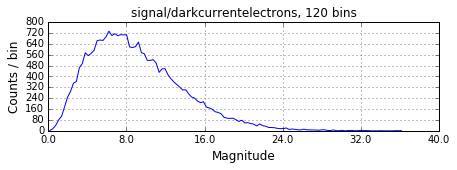

In [66]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/darkcurrentelectrons', bins=120) 



strh5 = ryfiles.open_HDF(hdffilenameIR)
print('Before dark FPN:')
print('Minimum dark current {:.3e} electrons'.format(np.min(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('Average dark current {:.3e} electrons'.format(np.mean(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('Maximum dark current {:.3e} electrons'.format(np.max(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('After dark FPN:')
print('Minimum dark current {:.3e} electrons'.format(np.min(strh5['rystare/signal/darkcurrentelectrons'].value)))
print('Average dark current {:.3e} electrons'.format(np.mean(strh5['rystare/signal/darkcurrentelectrons'].value)))
print('Maximum dark current {:.3e} electrons'.format(np.max(strh5['rystare/signal/darkcurrentelectrons'].value)))
strh5.flush()
strh5.close()

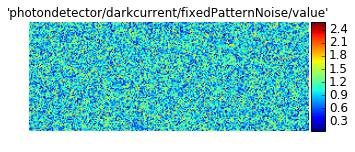

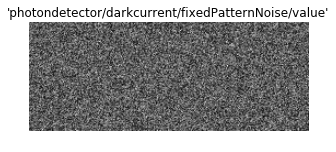

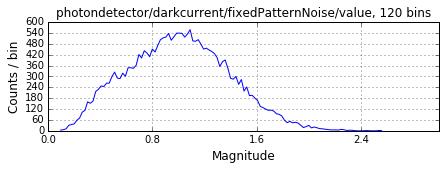

In [67]:
plotResults(imghd5, hdffilenameIR, 'rystare/photondetector/darkcurrent/fixedPatternNoise/value', bins=120) 

Location 11 in the diagram: dark current with noise multiplied with the dark current nonuniformity.\newline 
Variable: \url{rystare/signal/darkcurrentelectrons}.


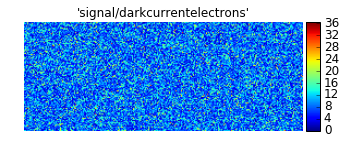

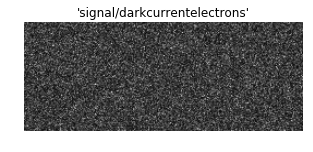

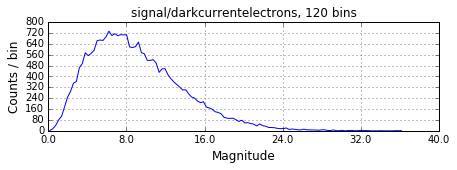

In [68]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/darkcurrentelectrons', bins=120) 

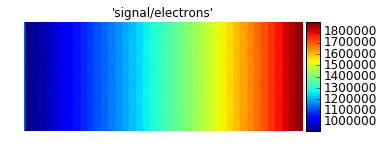

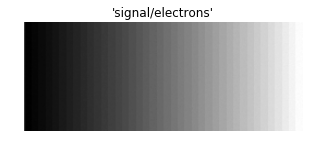

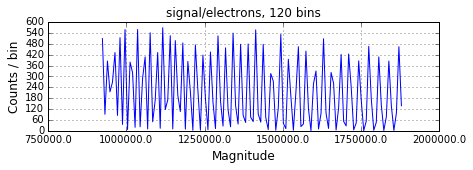

In [69]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electrons', bins=120) 

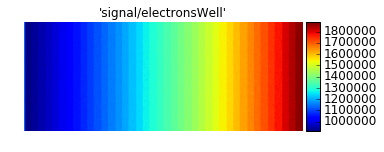

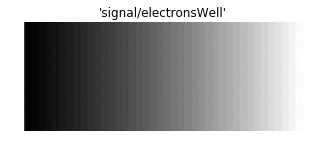

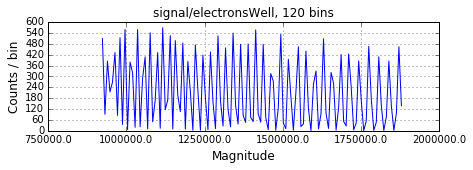

In [70]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electronsWell', bins=120) 


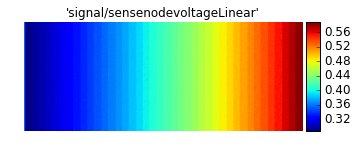

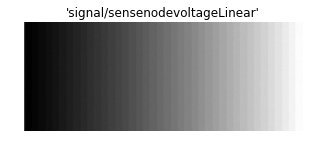

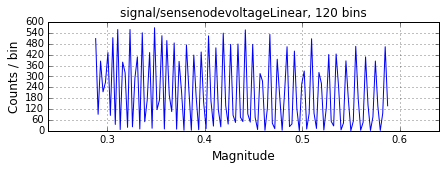

In [71]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/sensenodevoltageLinear', bins=120) 

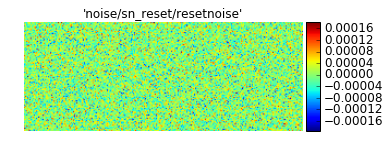

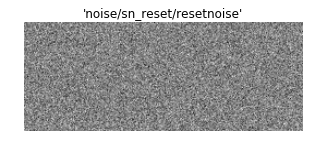

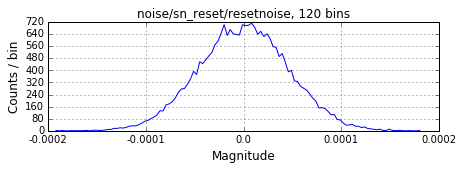

In [72]:
plotResults(imghd5, hdffilenameIR, 'rystare/noise/sn_reset/resetnoise', bins=120) 

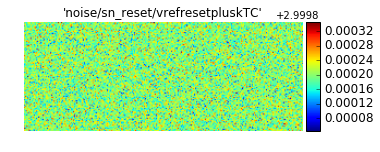

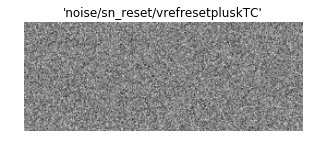

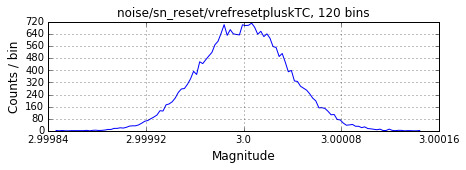

In [73]:
plotResults(imghd5, hdffilenameIR, 'rystare/noise/sn_reset/vrefresetpluskTC', bins=120) 

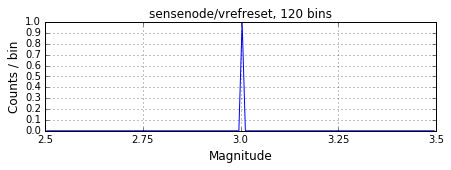

In [74]:
plotResults(imghd5, hdffilenameIR, 'rystare/sensenode/vrefreset', bins=120) 

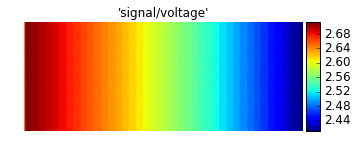

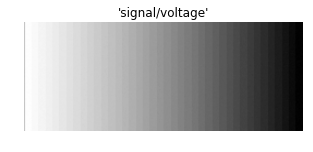

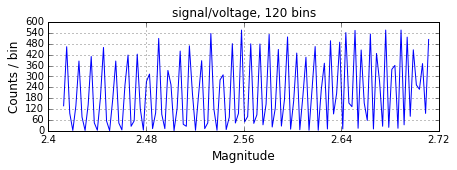

In [75]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltage', bins=120) 

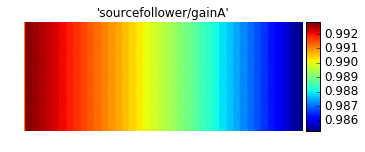

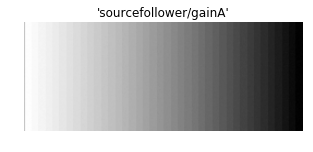

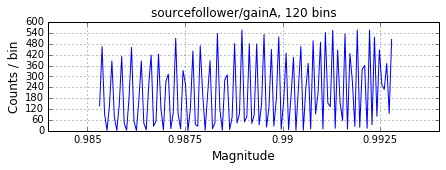

In [76]:
plotResults(imghd5, hdffilenameIR, 'rystare/sourcefollower/gainA', bins=120) 

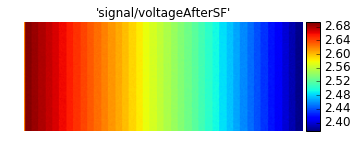

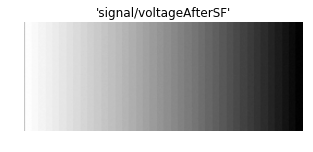

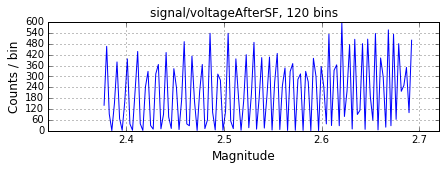

In [77]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltageAfterSF', bins=120) 

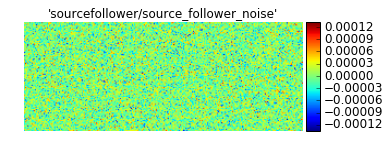

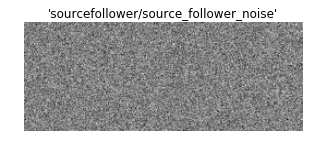

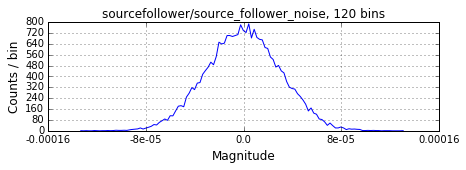

In [78]:
plotResults(imghd5, hdffilenameIR, 'rystare/sourcefollower/source_follower_noise', bins=120) 

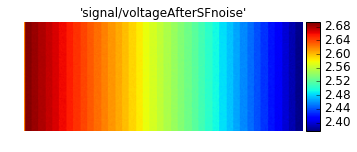

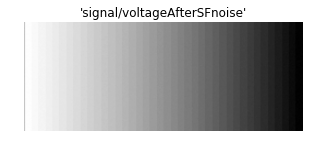

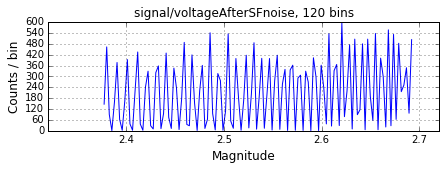

In [79]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltageAfterSFnoise', bins=120) 

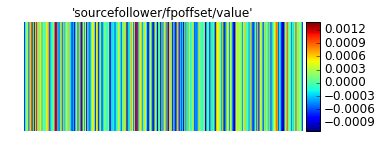

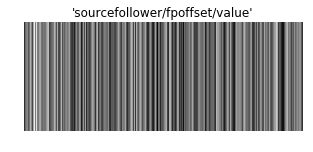

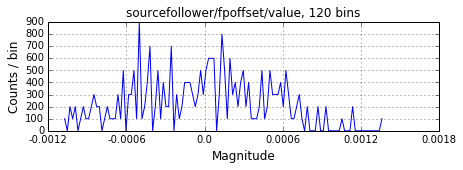

In [80]:
plotResults(imghd5, hdffilenameIR, 'rystare/sourcefollower/fpoffset/value', bins=120) 

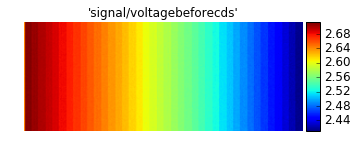

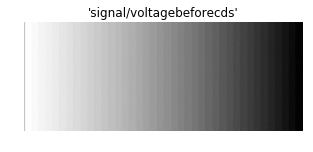

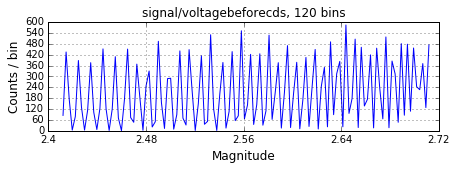

In [81]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltagebeforecds', bins=120) 

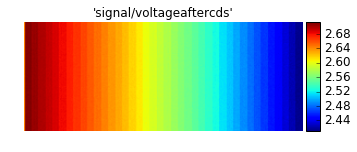

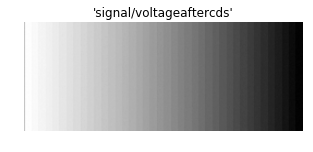

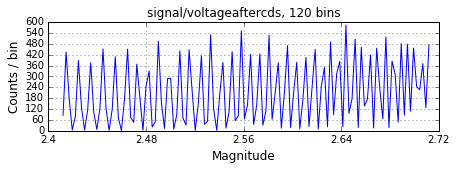

In [82]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltageaftercds', bins=120) 

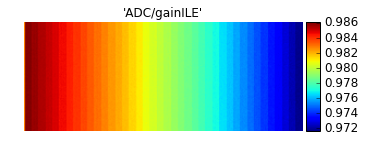

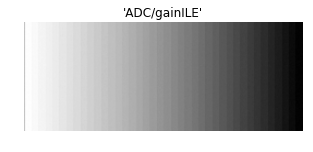

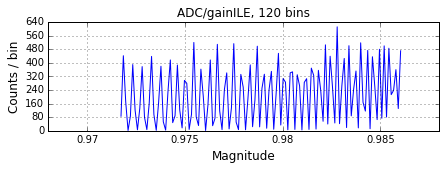

In [83]:
plotResults(imghd5, hdffilenameIR, 'rystare/ADC/gainILE', bins=120) 

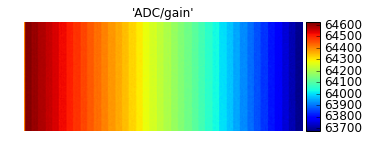

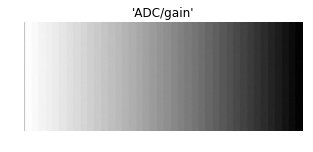

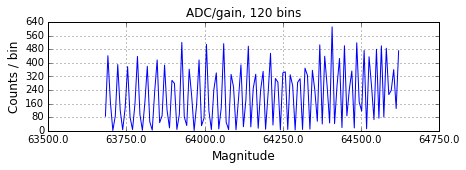

In [84]:
plotResults(imghd5, hdffilenameIR, 'rystare/ADC/gain', bins=120) 

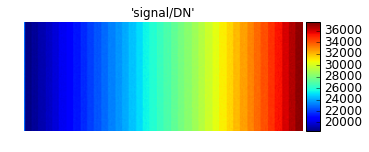

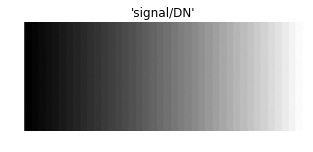

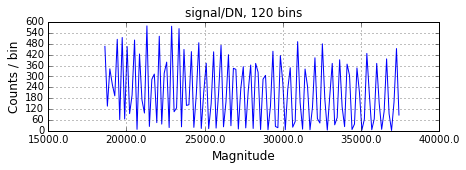

In [85]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/DN', bins=120) 

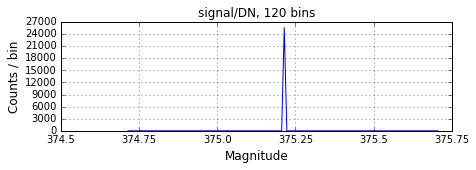

In [86]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/DN', bins=120, plotscale=100) 

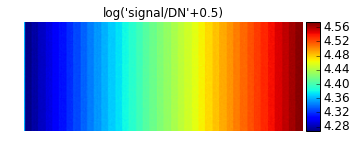

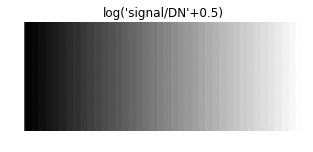

In [87]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/DN', bins=120, plotscale=1, logscale=True) 

Next we will attempt to calculate the photon transfer function and signal to noise ratio for the various parts of the image.

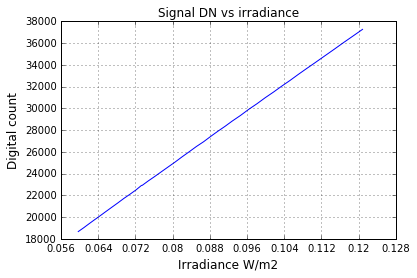

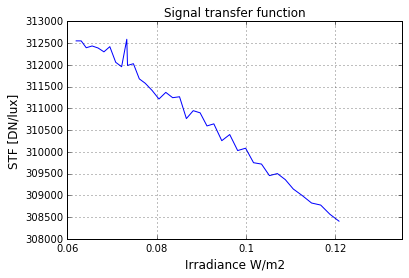

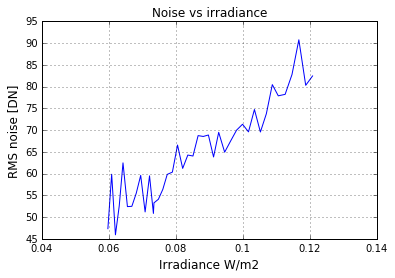

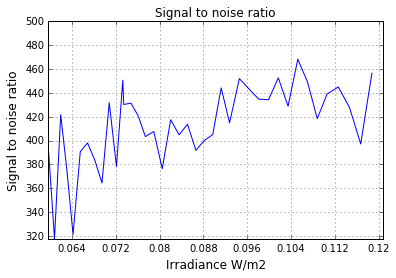

In [88]:
tplZones = collections.namedtuple('tplZones', ['ein', 'count','mean','var','std','snr','stf'], verbose=False)
lstZones = []
if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilenameIR)
    #get the list of unique zones in the image
    arrnn = strh5['rystare/equivalentSignal'].value
#     arrnn = strh5['rystare/PhotonRateIrradianceNoNoise'].value
    arr = strh5['rystare/signal/DN'].value
    uniqueZs, uCnts = np.unique(arrnn, return_counts=True)
#     print(uniqueZs, uCnts)
    for uniqueZ,ucnt in zip(uniqueZs,uCnts):
        zone = arr[arrnn==uniqueZ]
        mean = np.mean(zone)
        lstZones.append(tplZones(ein=uniqueZ, count=ucnt, mean=mean, 
                        var=np.var(zone-mean), std=np.std(zone-mean), 
                        snr=np.mean(zone)/np.std(zone-mean),
                        stf=np.mean(zone)/uniqueZ))
    equivalentSignalLabel = '{} {}'.format(strh5['rystare/equivalentSignalType'].value,
                                       strh5['rystare/equivalentSignalUnit'].value)

    strh5.flush()
    strh5.close()


# print(lstZones) 
#build numpy arrays of the results
ein = np.asarray([x.ein for x in lstZones])
mean = np.asarray([x.mean for x in lstZones])
var = np.asarray([x.var for x in lstZones])
std = np.asarray([x.std for x in lstZones])
snr = np.asarray([x.snr for x in lstZones])
stf = np.asarray([x.stf for x in lstZones])


figsize = (6,4)
p = ryplot.Plotter(1,1,1,figsize=figsize);
p.plot(1,ein,mean,'Signal DN vs irradiance',equivalentSignalLabel,'Digital count');
q = ryplot.Plotter(2,1,1,figsize=figsize);
q.plot(1,ein[2:],stf[2:],'Signal transfer function',equivalentSignalLabel,'STF [DN/lux]',maxNX=5);
r = ryplot.Plotter(3,1,1,figsize=figsize);
r.plot(1,ein,std,'Noise vs irradiance',equivalentSignalLabel,'RMS noise [DN]',maxNX=5);
s = ryplot.Plotter(4,1,1,figsize=figsize);
s.plot(1,ein[:-1],snr[:-1],'Signal to noise ratio',equivalentSignalLabel,'Signal to noise ratio',
        pltaxis=[ein[0],ein[-1], np.min(snr[:-1]),500]);
# s.logLog(1,mean[:-1],snr[:-1],'SNR [-] vs mean [DN]');


# Converting between radiant and photon rate units

Responsivity is given by
\begin{equation}
R_e = \frac{\eta q \lambda}{hc}
\end{equation}
from which quantum efficiency can be determined
\begin{equation}
\eta = \frac{R_e hc}{q \lambda} 
\end{equation}



wl min = 3.502627
wl mid = 4.1963013
wl max = 4.8899756


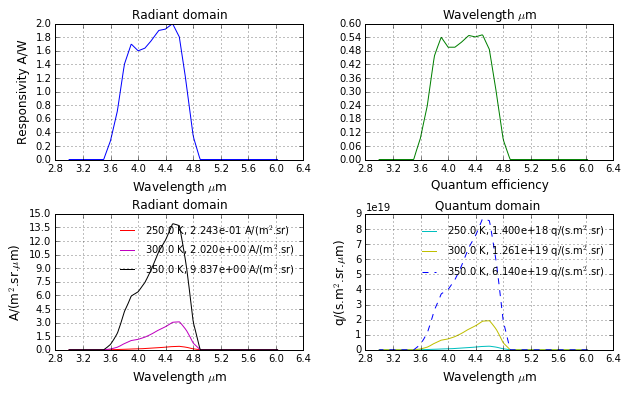

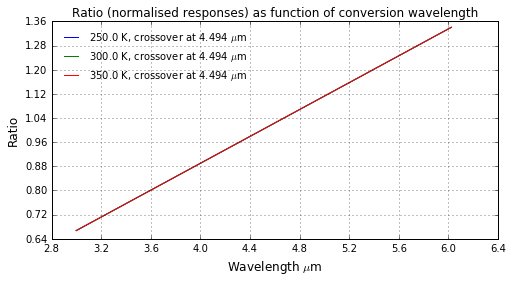

In [89]:
# to investigate the conversion for broadband data

spec = np.loadtxt('data/InSb.txt')
wl = spec[:,0].reshape(-1)
respW = 2. * spec[:,2].reshape(-1)
respQ = respW * const.h * const.c / (wl * 1e-6 * const.e)

wlNan = np.where(respW==0,np.nan,wl)
wlcent = np.mean([np.nanmax(wlNan),  np.nanmin(wlNan)])
print('wl min = {}'.format(np.nanmin(wlNan)))
print('wl mid = {}'.format(wlcent))
print('wl max = {}'.format(np.nanmax(wlNan)))

p = ryplot.Plotter(1,2,2,figsize=(10,6));
p.plot(1, wl,respW, 'Radiant domain','Wavelength $\mu$m','Responsivity A/W');
p.plot(2, wl,respQ,'Wavelength $\mu$m','Quantum efficiency');

q = ryplot.Plotter(2,1,1,figsize=(8,4))
for temp in [250.,300.,350.]:
    Ve = respW * ryplanck.planck(wl,temp,'el') / np.pi
    Vq = respQ * ryplanck.planck(wl,temp,'ql') / np.pi
    Vei = np.trapz(Ve,-wl,axis=0)
    Vqi = np.trapz(Vq,-wl,axis=0)
    
    # convert from W to q/s
    qW = const.h * const.c /  (wl * 1e-6)
    ratio =  ((Vei/qW) / Vqi ) / (np.max(respW)/np.max(respQ))
    wlu = np.interp(1.,ratio[::-1],wl[::-1])
    q.plot(1, wl,ratio, 'Ratio (normalised responses) as function of conversion wavelength',
           'Wavelength $\mu$m', 'Ratio',
           label=['{} K, crossover at {:.3f} $\mu$m'.format(temp,wlu)]);
    
    p.plot(3, wl,Ve, 'Radiant domain',
           'Wavelength $\mu$m', 'A/(m$^2$.sr.$\mu$m)',
           label=['{} K, {:.3e} A/(m$^2$.sr)'.format(temp,Vei)]);
    p.plot(4, wl,Vq, 'Quantum domain ',
           'Wavelength $\mu$m', 'q/(s.m$^2$.sr.$\mu$m)',
           label=['{} K, {:.3e} q/(s.m$^2$.sr)'.format(temp,Vqi)]);
#     p.plot(4, wl,Ve/const.e);


## Comments

1.  The small target image used here is relatively small and does not provide adequate statistics.  It serves as proof-of-concept in this analysis.

1. A more detailed discussion of the results will be done in due course.



## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [90]:
# you only need to do this once
#!pip install --upgrade version_information

%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pyradi 0.2.3
Fri Oct 21 09:30:08 2016 South Africa Standard Time